In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [18]:
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

X_train = Train.drop('STATUS', axis=1)
y_train = Train['STATUS']

X_test = Test.drop('STATUS', axis=1)
y_test = Test['STATUS']

In [19]:
def train_dnn(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    best_metrics = {'accuracy': 0}
    best_model = None
    best_params = {}

    for units in [64, 128, 256]:
        for dropout_rate in [0.0, 0.2, 0.5]:
            for activation in ['relu', 'tanh']:
                fold_accuracies = []
                for train_index, test_index in kf.split(X):
                    model = Sequential([
                        Input(shape=(X.shape[1],)),
                        Dense(units, activation=activation),
                        Dropout(dropout_rate),
                        Dense(units // 2, activation=activation),
                        Dropout(dropout_rate),
                        Dense(1, activation='sigmoid')
                    ])
                    model.compile(optimizer='adam', loss='binary_crossentropy')
                    
                    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
                    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
                    
                    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=16, verbose=0)
                    y_pred = (model.predict(X_test_fold, verbose=0) > 0.5).astype("int32")

                    acc = accuracy_score(y_test_fold, y_pred)
                    fold_accuracies.append(acc)
                
                avg_acc = np.mean(fold_accuracies)
                if avg_acc > best_metrics['accuracy']:
                    best_metrics['accuracy'] = avg_acc
                    best_metrics['recall'] = recall_score(y_test_fold, y_pred)
                    best_metrics['precision'] = precision_score(y_test_fold, y_pred)
                    best_metrics['f1'] = f1_score(y_test_fold, y_pred)
                    best_metrics['kappa'] = cohen_kappa_score(y_test_fold, y_pred)
                    best_model = model
                    best_params = {'units': units, 'dropout_rate': dropout_rate, 'activation': activation}
    
    print("Best DNN Model Results:")
    print(f"Hyperparameters - Units: {best_params['units']}, Dropout Rate: {best_params['dropout_rate']}, Activation: {best_params['activation']}")
    print(f"Accuracy: {best_metrics['accuracy']:.3f}")
    print(f"Recall: {best_metrics['recall']:.3f}")
    print(f"Precision: {best_metrics['precision']:.3f}")
    print(f"F1-Score: {best_metrics['f1']:.3f}")
    print(f"Kappa: {best_metrics['kappa']:.3f}")

    return best_model


In [20]:
def train_mlp(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    architectures = [[10], [20], [50], [10, 10], [20, 20], [50, 50], [100, 50], [100, 50, 25]]
    solvers = ['adam', 'sgd']
    activations = ['relu', 'tanh']
    
    best_metrics = {'accuracy': 0}
    best_params = {}
    best_model = None
    
    for hidden_layer_sizes in architectures:
        for solver in solvers:
            for activation in activations:
                accuracies, recalls, precisions, f1_scores, kappas = [], [], [], [], []
                
                for train_index, test_index in kf.split(X):
                    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
                    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

                    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver=solver, activation=activation, random_state=1, max_iter=5000)
                    model.fit(X_train_fold, y_train_fold)
                    y_pred = model.predict(X_test_fold)
                    
                    accuracies.append(accuracy_score(y_test_fold, y_pred))
                    recalls.append(recall_score(y_test_fold, y_pred, average='weighted'))
                    precisions.append(precision_score(y_test_fold, y_pred, average='weighted'))
                    f1_scores.append(f1_score(y_test_fold, y_pred, average='weighted'))
                    kappas.append(cohen_kappa_score(y_test_fold, y_pred))
                
                avg_acc = np.mean(accuracies)
                if avg_acc > best_metrics['accuracy']:
                    best_metrics['accuracy'] = avg_acc
                    best_metrics['recall'] = np.mean(recalls)
                    best_metrics['precision'] = np.mean(precisions)
                    best_metrics['f1'] = np.mean(f1_scores)
                    best_metrics['kappa'] = np.mean(kappas)
                    best_params = {'architecture': hidden_layer_sizes, 'solver': solver, 'activation': activation}
                    best_model = model
    
    print("Best MLP Model Results:")
    print(f"Architecture: {best_params['architecture']}, Solver: {best_params['solver']}, Activation: {best_params['activation']}")
    print(f"Accuracy: {best_metrics['accuracy']:.3f}")
    print(f"Recall: {best_metrics['recall']:.3f}")
    print(f"Precision: {best_metrics['precision']:.3f}")
    print(f"F1-Score: {best_metrics['f1']:.3f}")
    print(f"Kappa: {best_metrics['kappa']:.3f}")
    
    return best_model


In [21]:
def plot_combined_roc(models, X, y, model_names):
    """
    Function to plot ROC curves for multiple models on the same plot.

    Parameters:
    - models: List of trained models
    - X: Input features (test set)
    - y: True labels (test set)
    - model_names: List of model names corresponding to each model
    """
    plt.figure()

    for model, name in zip(models, model_names):
        # Check if model has `predict_proba` or `predict`
        if hasattr(model, "predict_proba"):
            y_pred_prob = model.predict_proba(X)[:, 1]
        else:
            y_pred_prob = model.predict(X)[:, 0]  # For Keras models

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    # Plot settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


Best DNN Model Results:
Hyperparameters - Units: 256, Dropout Rate: 0.2, Activation: relu
Accuracy: 0.964
Recall: 0.963
Precision: 0.966
F1-Score: 0.964
Kappa: 0.929
Best MLP Model Results:
Architecture: [100, 50], Solver: adam, Activation: tanh
Accuracy: 0.973
Recall: 0.973
Precision: 0.973
F1-Score: 0.973
Kappa: 0.946
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


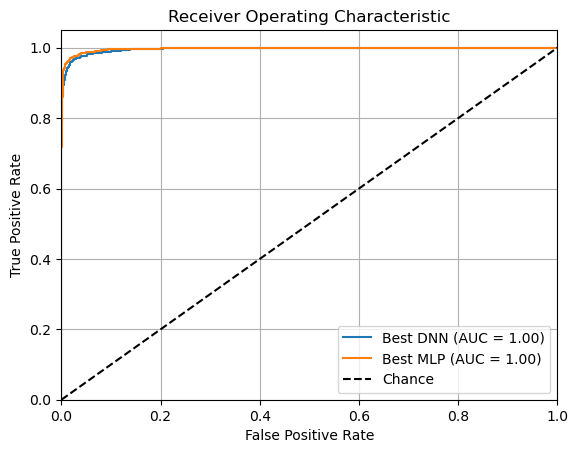

In [22]:
# Example integration with your existing code
best_dnn_model = train_dnn(X_train, y_train)  # Assuming this returns the best trained DNN model
best_mlp_model = train_mlp(X_train, y_train)  # Assuming this returns the best trained MLP model

# Combine and plot
plot_combined_roc(
    models=[best_dnn_model, best_mlp_model],
    X=X_test,
    y=y_test,
    model_names=["Best DNN", "Best MLP"]
)


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


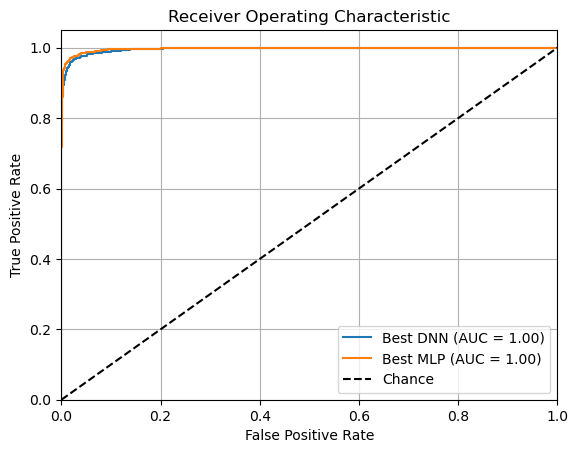

In [23]:
plot_combined_roc(
    models=[best_dnn_model, best_mlp_model],
    X=X_test,
    y=y_test,
    model_names=["Best DNN", "Best MLP"]
)